In [1]:
import pandas as pd
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Bidirectional 
from keras import Model
from keras import optimizers
from tensorflow import keras

In [2]:
data_full = pd.read_csv('Intraday Volatility Dataset.csv')

In [3]:
X = data_full[["Volume", "Return", "Return_Squared", "EMAF", "Daily Volatility"]]
Y = data_full["target"]
data_set = data_full[["Date", "Volume", "Return", "Return_Squared", "EMAF", "Daily Volatility", "target"]]

In [4]:
splitlimit = int(len(data_set)*0.8)
training_features, test_data = data_set[:splitlimit], data_set[splitlimit:]

In [5]:

training_features["volatility_rolling_median"] = training_features["Daily Volatility"].rolling(window=41, center=True, min_periods=1).median()
training_features["return_squared_rolling_median"] = training_features["Return_Squared"].rolling(window=41, center=True, min_periods=1).median()
training_features["return_rolling_median"] = training_features["Return"].rolling(window=41, center=True, min_periods=1).median()
training_features["EMAF_rolling_median"] = training_features["EMAF"].rolling(window=41, center=True, min_periods=1).median()
training_features["volume_rolling_median"] = training_features["Volume"].rolling(window=41, center=True, min_periods=1).median()

training_features["volatility minus median"] = (training_features["Daily Volatility"] - training_features["volatility_rolling_median"]).abs()
training_features["return_squared minus median"] = (training_features["Return_Squared"] - training_features["return_squared_rolling_median"]).abs()
training_features["return minus median"] = (training_features["Return"] - training_features["return_rolling_median"]).abs()
training_features["EMAF minus median"] = (training_features["EMAF"] - training_features["EMAF_rolling_median"]).abs()
training_features["volume minus median"] = (training_features["Volume"] - training_features["volume_rolling_median"]).abs()

volatility_outliers_removed = training_features[~(training_features['volatility minus median'] > 5 * training_features['volatility minus median'].median())]
all_outliers_removed = volatility_outliers_removed[~(volatility_outliers_removed['return_squared minus median'] > 5 * volatility_outliers_removed['return_squared minus median'].median())]
all_outliers_removed = all_outliers_removed[~(all_outliers_removed['return minus median'] > 5 * volatility_outliers_removed['return minus median'].median())]
all_outliers_removed = all_outliers_removed[~(all_outliers_removed['EMAF minus median'] > 5 * volatility_outliers_removed['EMAF minus median'].median())]
all_outliers_removed = all_outliers_removed[~(all_outliers_removed['volume minus median'] > 5 * volatility_outliers_removed['volume minus median'].median())]

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_20046/535166735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_features["volatility_rolling_median"] = training_features["Daily Volatility"].rolling(window=41, center=True, min_periods=1).median()
/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_20046/535166735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_features["return_squared_rolling_median"] = training_features["Return_Squared"].rolling(window=41, center=

In [6]:
X_cleaned = all_outliers_removed[["Volume", "Return", "Return_Squared", "EMAF", "Daily Volatility"]]
Y_cleaned = all_outliers_removed["target"]
data_set_cleaned = all_outliers_removed[["Volume", "Return", "Return_Squared", "EMAF", "Daily Volatility", "target"]]

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
training_data_features_scaled = scaler.fit_transform(X_cleaned)
data_set_scaled = scaler.fit_transform(data_set_cleaned)

In [8]:
Z = []

backcandles = 10

for j in range(5):
    Z.append([])
    for i in range(backcandles, training_data_features_scaled.shape[0]):
        Z[j].append(training_data_features_scaled[i-backcandles:i, j])

In [9]:
Z = np.moveaxis(Z, [0], [2])
Z, yi = np.array(Z), np.array(data_set_scaled[backcandles-1:, -1])
y_final = np.reshape(yi,(len(yi),1))
y_final = y_final[1:]

In [10]:
#Random Search and Walk-Forward Cross-Validation


from keras.models import load_model
from sklearn.model_selection import ParameterSampler
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Activation
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import numpy as np
from scipy.stats import randint, uniform


def create_model(units=80):
    lstm_input = Input(shape=(backcandles, 5), name='lstm_input')
    inputs = LSTM(units, name='first_layer')(lstm_input)
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('sigmoid', name='output')(inputs)
    model = Model(inputs=lstm_input, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model



#hyperparameter space
param_dist = {
    'units': randint(50, 150),  
    'batch_size': [16, 32, 64],  
    'epochs': randint(10,30), 
}


best_score = -np.inf  # Initialize best score
best_params = None  # Initialize best parameters
best_model_path = "best_model.h5"  # Path to save the best model

n_iter = 50  # Number of iterations for random search
tscv = TimeSeriesSplit(n_splits=5)
best_score = -np.inf 
best_params = None  

for params in ParameterSampler(param_dist, n_iter=n_iter):
    fold_scores = []  # Store scores for each fold
    
    for train_index, test_index in tscv.split(Z):
        # Split data
        X_train_fold, X_val_fold = Z[train_index], Z[test_index]
        y_train_fold, y_val_fold = y_final[train_index], y_final[test_index]
        
        # Create model
        model = create_model(units=params['units'])
        
        # Compile model with the chosen hyperparameters
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        
        # Fit the model
        model.fit(X_train_fold, y_train_fold, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)
        
        # Evaluate the model
        _, score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_scores.append(score)
    
    # Compute the average score across all folds
    avg_score = np.mean(fold_scores)
    
    # If the current model's score is better, update best score, parameters, and save the model
    if avg_score > best_score:
        best_score = avg_score
        best_params = params
        
        # Save the current best model
        model.save(best_model_path)
        print(f"New best model saved with score: {avg_score}")
        
# After the search
print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")


2024-04-19 17:20:33.533314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-04-19 17:20:33.533449: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5556
Epoch 2/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5556
Epoch 3/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5556
Epoch 4/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5556
Epoch 5/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5556
Epoch 6/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5556
Epoch 7/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5556
Epoch 8/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5556
Epoch 9/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5556
Epoch 10/29
5/5 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5556
Epoch 11/29
5/5 [======================

18/18 [==============================] - 0s 1ms/step - loss: 0.6644 - accuracy: 0.5694
Epoch 23/24
18/18 [==============================] - 0s 1ms/step - loss: 0.6619 - accuracy: 0.5903
Epoch 24/24
18/18 [==============================] - 0s 1ms/step - loss: 0.6566 - accuracy: 0.6042
Epoch 1/24
36/36 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5279
Epoch 2/24
36/36 [==============================] - 0s 2ms/step - loss: 0.6904 - accuracy: 0.5383
Epoch 3/24
36/36 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.5383
Epoch 4/24
36/36 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.5383
Epoch 5/24
36/36 [==============================] - 0s 2ms/step - loss: 0.6871 - accuracy: 0.5383
Epoch 6/24
36/36 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.5383
Epoch 7/24
36/36 [==============================] - 0s 2ms/step - loss: 0.6873 - accuracy: 0.5366
Epoch 8/24
36/36 [===========

54/54 [==============================] - 0s 2ms/step - loss: 0.6339 - accuracy: 0.6477
Epoch 16/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.6453
Epoch 17/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6276 - accuracy: 0.6430
Epoch 18/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6238 - accuracy: 0.6547
Epoch 19/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6232 - accuracy: 0.6674
Epoch 20/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.6395
Epoch 21/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6206 - accuracy: 0.6616
Epoch 22/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6197 - accuracy: 0.6581
Epoch 23/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6174 - accuracy: 0.6733
Epoch 24/26
54/54 [==============================] - 0s 2ms/step - loss: 0.6132 - accuracy: 0.6709
Epoch 25/26
54/54 [===

9/9 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5383
Epoch 1/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5267
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5477
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5477
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5477
Epoch 5/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5477
Epoch 6/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5488
Epoch 7/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5500
Epoch 8/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6848 - accuracy: 0.5477
Epoch 9/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5512
Epoch 10/10
14/14 [==============

72/72 [==============================] - 0s 2ms/step - loss: 0.6375 - accuracy: 0.6457
Epoch 14/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6361 - accuracy: 0.6501
Epoch 15/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6510
Epoch 16/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.6527
Epoch 17/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.6510
Epoch 18/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6233 - accuracy: 0.6684
Epoch 19/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6217 - accuracy: 0.6693
Epoch 20/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.6702
Epoch 21/21
72/72 [==============================] - 0s 2ms/step - loss: 0.6196 - accuracy: 0.6675
Epoch 1/21
90/90 [==============================] - 1s 2ms/step - loss: 0.6901 - accuracy: 0.5412
Epoch 2/21
90/90 [=====

18/18 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.5383
Epoch 14/15
18/18 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.5401
Epoch 15/15
18/18 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.5436
Epoch 1/15
27/27 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5453
Epoch 2/15
27/27 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5477
Epoch 3/15
27/27 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5477
Epoch 4/15
27/27 [==============================] - 0s 2ms/step - loss: 0.6872 - accuracy: 0.5477
Epoch 5/15
27/27 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5477
Epoch 6/15
27/27 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5477
Epoch 7/15
27/27 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5477
Epoch 8/15
27/27 [===========

18/18 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.5454
Epoch 12/18
18/18 [==============================] - 0s 2ms/step - loss: 0.6802 - accuracy: 0.5515
Epoch 13/18
18/18 [==============================] - 0s 2ms/step - loss: 0.6784 - accuracy: 0.5506
Epoch 14/18
18/18 [==============================] - 0s 2ms/step - loss: 0.6752 - accuracy: 0.5585
Epoch 15/18
18/18 [==============================] - 0s 2ms/step - loss: 0.6708 - accuracy: 0.5733
Epoch 16/18
18/18 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.5942
Epoch 17/18
18/18 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.6091
Epoch 18/18
18/18 [==============================] - 0s 2ms/step - loss: 0.6652 - accuracy: 0.6152
Epoch 1/18
23/23 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5391
Epoch 2/18
23/23 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5426
Epoch 3/18
23/23 [======

18/18 [==============================] - 0s 2ms/step - loss: 0.6855 - accuracy: 0.5556
Epoch 7/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5556
Epoch 8/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5556
Epoch 9/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5556
Epoch 10/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6831 - accuracy: 0.5556
Epoch 11/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6827 - accuracy: 0.5556
Epoch 12/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.5556
Epoch 13/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6809 - accuracy: 0.5556
Epoch 14/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.5556
Epoch 15/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.5556
Epoch 16/20
18/18 [======

45/45 [==============================] - 0s 2ms/step - loss: 0.6432 - accuracy: 0.6494
Epoch 13/15
45/45 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.6585
Epoch 14/15
45/45 [==============================] - 0s 2ms/step - loss: 0.6387 - accuracy: 0.6327
Epoch 15/15
45/45 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.6453
Epoch 1/10
9/9 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5556
Epoch 2/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.5556
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6872 - accuracy: 0.5556
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6875 - accuracy: 0.5556
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6869 - accuracy: 0.5556
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5556
Epoch 7/10
9/9 [========================

18/18 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6754
Epoch 28/29
18/18 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6649
Epoch 29/29
18/18 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6640
Epoch 1/29
23/23 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5244
Epoch 2/29
23/23 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5426
Epoch 3/29
23/23 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5426
Epoch 4/29
23/23 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5426
Epoch 5/29
23/23 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5433
Epoch 6/29
23/23 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5419
Epoch 7/29
23/23 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5489
Epoch 8/29
23/23 [===========

9/9 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5418
Epoch 18/23
9/9 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5436
Epoch 19/23
9/9 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5784
Epoch 20/23
9/9 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5436
Epoch 21/23
9/9 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5627
Epoch 22/23
9/9 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5697
Epoch 23/23
9/9 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5436
Epoch 1/23
14/14 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5407
Epoch 2/23
14/14 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5477
Epoch 3/23
14/14 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5477
Epoch 4/23
14/14 [=====================

5/5 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5556
Epoch 2/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5556
Epoch 3/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5556
Epoch 4/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5556
Epoch 5/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.5556
Epoch 6/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5556
Epoch 7/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.5556
Epoch 8/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5556
Epoch 9/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5556
Epoch 10/19
5/5 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5556
Epoch 11/19
5/5 [==============================] -

23/23 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5440
Epoch 10/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.5440
Epoch 11/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.5454
Epoch 12/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.5901
Epoch 13/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6733 - accuracy: 0.5887
Epoch 14/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6697 - accuracy: 0.5866
Epoch 15/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.6047
Epoch 16/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6653 - accuracy: 0.5971
Epoch 17/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6614 - accuracy: 0.6089
Epoch 18/19
23/23 [==============================] - 0s 2ms/step - loss: 0.6579 - accuracy: 0.6208
Epoch 19/19
23/23 [===

72/72 [==============================] - 0s 2ms/step - loss: 0.6271 - accuracy: 0.6815
Epoch 18/23
72/72 [==============================] - 0s 2ms/step - loss: 0.6208 - accuracy: 0.6649
Epoch 19/23
72/72 [==============================] - 0s 2ms/step - loss: 0.6183 - accuracy: 0.6693
Epoch 20/23
72/72 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6693
Epoch 21/23
72/72 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6614
Epoch 22/23
72/72 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6702
Epoch 23/23
72/72 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6798
Epoch 1/23
90/90 [==============================] - 1s 3ms/step - loss: 0.6915 - accuracy: 0.5426
Epoch 2/23
90/90 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5426
Epoch 3/23
90/90 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5426
Epoch 4/23
90/90 [=======

14/14 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.5512
Epoch 18/19
14/14 [==============================] - 0s 4ms/step - loss: 0.6714 - accuracy: 0.5767
Epoch 19/19
14/14 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6047
Epoch 1/19
18/18 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5419
Epoch 2/19
18/18 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5445
Epoch 3/19
18/18 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5445
Epoch 4/19
18/18 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5445
Epoch 5/19
18/18 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5445
Epoch 6/19
18/18 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5436
Epoch 7/19
18/18 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5445
Epoch 8/19
18/18 [===========

14/14 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5500
Epoch 12/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5616
Epoch 13/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5535
Epoch 14/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.6140
Epoch 15/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5500
Epoch 16/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5523
Epoch 17/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5674
Epoch 18/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5744
Epoch 19/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6209
Epoch 20/28
14/14 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.5977
Epoch 21/28
14/14 [===

18/18 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6230
Epoch 17/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6318
Epoch 18/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6501
Epoch 19/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6344
Epoch 20/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6283
Epoch 21/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6571
Epoch 22/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6579
Epoch 23/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6518
Epoch 24/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6597
Epoch 25/26
18/18 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6335
Epoch 26/26
18/18 [===

90/90 [==============================] - 0s 2ms/step - loss: 0.6616 - accuracy: 0.6166
Epoch 8/12
90/90 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.6236
Epoch 9/12
90/90 [==============================] - 0s 2ms/step - loss: 0.6446 - accuracy: 0.6411
Epoch 10/12
90/90 [==============================] - 0s 2ms/step - loss: 0.6368 - accuracy: 0.6522
Epoch 11/12
90/90 [==============================] - 0s 2ms/step - loss: 0.6330 - accuracy: 0.6508
Epoch 12/12
90/90 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6578
Epoch 1/27
18/18 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5278
Epoch 2/27
18/18 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.5556
Epoch 3/27
18/18 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.5556
Epoch 4/27
18/18 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5556
Epoch 5/27
18/18 [==========

14/14 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5488
Epoch 7/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5477
Epoch 8/10
14/14 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5477
Epoch 9/10
14/14 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5500
Epoch 10/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5488
Epoch 1/10
18/18 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5366
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5445
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5445
Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5445
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5445
Epoch 6/10
18/18 [============

36/36 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6370
Epoch 15/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6300
Epoch 16/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6396
Epoch 17/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6483
Epoch 18/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6553
Epoch 19/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6414
Epoch 20/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6571
Epoch 21/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6719
Epoch 22/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6675
Epoch 23/26
36/36 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6667
Epoch 24/26
36/36 [===

14/14 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5279
Epoch 3/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5488
Epoch 4/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5477
Epoch 5/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5477
Epoch 6/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5477
Epoch 7/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5477
Epoch 8/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5477
Epoch 9/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5477
Epoch 10/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5477
Epoch 11/22
14/14 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5500
Epoch 12/22
14/14 [==========

27/27 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5500
Epoch 9/12
27/27 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5547
Epoch 10/12
27/27 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5547
Epoch 11/12
27/27 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5884
Epoch 12/12
27/27 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5814
Epoch 1/12
36/36 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5218
Epoch 2/12
36/36 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5445
Epoch 3/12
36/36 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5445
Epoch 4/12
36/36 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5445
Epoch 5/12
36/36 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5454
Epoch 6/12
36/36 [==========

36/36 [==============================] - 0s 2ms/step - loss: 0.6881 - accuracy: 0.5383
Epoch 6/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6881 - accuracy: 0.5383
Epoch 7/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.5383
Epoch 8/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6845 - accuracy: 0.5383
Epoch 9/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6815 - accuracy: 0.5436
Epoch 10/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6789 - accuracy: 0.5540
Epoch 11/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6738 - accuracy: 0.5784
Epoch 12/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6755 - accuracy: 0.5575
Epoch 13/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6719 - accuracy: 0.5627
Epoch 14/28
36/36 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.6220
Epoch 15/28
36/36 [=======

36/36 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.5515
Epoch 9/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5794
Epoch 10/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5942
Epoch 11/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.6012
Epoch 12/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6030
Epoch 13/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6204
Epoch 14/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6387
Epoch 15/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6318
Epoch 16/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6326
Epoch 17/17
36/36 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6510
Epoch 1/17
45/45 [=====

18/18 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5418
Epoch 12/14
18/18 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5418
Epoch 13/14
18/18 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5784
Epoch 14/14
18/18 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.5836
Epoch 1/14
27/27 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5302
Epoch 2/14
27/27 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5477
Epoch 3/14
27/27 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5477
Epoch 4/14
27/27 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5477
Epoch 5/14
27/27 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5477
Epoch 6/14
27/27 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5477
Epoch 7/14
27/27 [==========

9/9 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5418
Epoch 18/22
9/9 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.5418
Epoch 19/22
9/9 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5418
Epoch 20/22
9/9 [==============================] - 0s 2ms/step - loss: 0.6833 - accuracy: 0.5575
Epoch 21/22
9/9 [==============================] - 0s 2ms/step - loss: 0.6825 - accuracy: 0.5523
Epoch 22/22
9/9 [==============================] - 0s 2ms/step - loss: 0.6810 - accuracy: 0.5401
Epoch 1/22
14/14 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5395
Epoch 2/22
14/14 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5477
Epoch 3/22
14/14 [==============================] - 0s 2ms/step - loss: 0.6884 - accuracy: 0.5477
Epoch 4/22
14/14 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.5477
Epoch 5/22
14/14 [====================

18/18 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.6042
Epoch 21/24
18/18 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.5729
Epoch 22/24
18/18 [==============================] - 0s 2ms/step - loss: 0.6637 - accuracy: 0.5799
Epoch 23/24
18/18 [==============================] - 0s 2ms/step - loss: 0.6560 - accuracy: 0.5868
Epoch 24/24
18/18 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.6076
Epoch 1/24
36/36 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5105
Epoch 2/24
36/36 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5383
Epoch 3/24
36/36 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5383
Epoch 4/24
36/36 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5383
Epoch 5/24
36/36 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5383
Epoch 6/24
36/36 [=========

90/90 [==============================] - 0s 1ms/step - loss: 0.6888 - accuracy: 0.5349
Epoch 3/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5426
Epoch 4/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6857 - accuracy: 0.5440
Epoch 5/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6826 - accuracy: 0.5587
Epoch 6/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6787 - accuracy: 0.5642
Epoch 7/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6731 - accuracy: 0.5775
Epoch 8/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6670 - accuracy: 0.5978
Epoch 9/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6556 - accuracy: 0.6383
Epoch 10/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6476 - accuracy: 0.6327
Epoch 11/16
90/90 [==============================] - 0s 1ms/step - loss: 0.6450 - accuracy: 0.6369
Epoch 12/16
90/90 [==========

90/90 [==============================] - 0s 1ms/step - loss: 0.6217 - accuracy: 0.6711
Epoch 18/20
90/90 [==============================] - 0s 1ms/step - loss: 0.6194 - accuracy: 0.6669
Epoch 19/20
90/90 [==============================] - 0s 1ms/step - loss: 0.6158 - accuracy: 0.6781
Epoch 20/20
90/90 [==============================] - 0s 1ms/step - loss: 0.6160 - accuracy: 0.6704
Epoch 1/11
18/18 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5417
Epoch 2/11
18/18 [==============================] - 0s 1ms/step - loss: 0.6863 - accuracy: 0.5556
Epoch 3/11
18/18 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5556
Epoch 4/11
18/18 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5556
Epoch 5/11
18/18 [==============================] - 0s 1ms/step - loss: 0.6854 - accuracy: 0.5556
Epoch 6/11
18/18 [==============================] - 0s 1ms/step - loss: 0.6853 - accuracy: 0.5556
Epoch 7/11
18/18 [==========

45/45 [==============================] - 0s 2ms/step - loss: 0.6275 - accuracy: 0.6418
Epoch 21/22
45/45 [==============================] - 0s 2ms/step - loss: 0.6237 - accuracy: 0.6655
Epoch 22/22
45/45 [==============================] - 0s 2ms/step - loss: 0.6222 - accuracy: 0.6725
Epoch 1/16
18/18 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5278
Epoch 2/16
18/18 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.5556
Epoch 3/16
18/18 [==============================] - 0s 2ms/step - loss: 0.6879 - accuracy: 0.5556
Epoch 4/16
18/18 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5556
Epoch 5/16
18/18 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.5556
Epoch 6/16
18/18 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5556
Epoch 7/16
18/18 [==============================] - 0s 2ms/step - loss: 0.6847 - accuracy: 0.5556
Epoch 8/16
18/18 [===========

Epoch 1/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5521
Epoch 2/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5556
Epoch 3/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.5556
Epoch 4/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5556
Epoch 5/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.5556
Epoch 6/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5556
Epoch 7/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5556
Epoch 8/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5556
Epoch 9/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5556
Epoch 10/26
9/9 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5556
Epoch 11/26
9/9 [======================

36/36 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5454
Epoch 8/10
36/36 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5506
Epoch 9/10
36/36 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5646
Epoch 10/10
36/36 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5462
Epoch 1/10
45/45 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5419
Epoch 2/10
45/45 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5426
Epoch 3/10
45/45 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5426
Epoch 4/10
45/45 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5426
Epoch 5/10
45/45 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5426
Epoch 6/10
45/45 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5628
Epoch 7/10
45/45 [============

In [11]:
# Load the best model
best_model = load_model(best_model_path)

In [12]:
X_test = test_data[["Volume", "Return", "Return_Squared", "EMAF", "Daily Volatility"]]
Y_test = test_data["target"]
test_dataset = test_data[["Volume", "Return", "Return_Squared", "EMAF", "Daily Volatility", "target"]]

In [13]:
#Scaling test data
test_scaled = scaler.fit_transform(test_dataset)
X_test_scaled = scaler.fit_transform(X_test)

In [14]:
#reconstructing test data 


T = []

backcandles = 10

for j in range(5):
    T.append([])
    for i in range(backcandles, X_test_scaled.shape[0]):
        T[j].append(X_test_scaled[i-backcandles:i, j])
        
        
T = np.moveaxis(T, [0], [2])
T, yi_test = np.array(T), np.array(test_scaled[backcandles-1:, -1])
y_final_test = np.reshape(yi_test,(len(yi_test),1))
y_final_test = y_final_test[1:]

In [15]:
#lstm in sample 
from sklearn.metrics import confusion_matrix

validation_predictions = best_model.predict(Z)
validation_predicted_classes = (validation_predictions > 0.5).astype(int)
dataframe_val = pd.DataFrame(y_final, columns = ["target"])
dataframe_val["predicted"] = validation_predicted_classes
cm = confusion_matrix(dataframe_val['predicted'], dataframe_val['target'])
print(cm)

[[705 318]
 [225 470]]


In [19]:
#lstm out of sample
test_predictions = best_model.predict(T)
test_predicted_classes = (test_predictions > 0.5).astype(int)
dataframe = pd.DataFrame(y_final_test, columns = ["target"])
dataframe["predicted"] = test_predicted_classes
cm = confusion_matrix(dataframe['predicted'], dataframe['target'])
print(cm)

[[344 163]
 [142 296]]


AUC: 0.7529
Threshold: inf, 1-Specificity: 0.00, Sensitivity: 0.00
Threshold: 0.88, 1-Specificity: 0.00, Sensitivity: 0.00
Threshold: 0.77, 1-Specificity: 0.00, Sensitivity: 0.01
Threshold: 0.77, 1-Specificity: 0.00, Sensitivity: 0.01
Threshold: 0.75, 1-Specificity: 0.00, Sensitivity: 0.02
Threshold: 0.74, 1-Specificity: 0.00, Sensitivity: 0.02
Threshold: 0.72, 1-Specificity: 0.00, Sensitivity: 0.03
Threshold: 0.72, 1-Specificity: 0.01, Sensitivity: 0.03
Threshold: 0.69, 1-Specificity: 0.01, Sensitivity: 0.06
Threshold: 0.69, 1-Specificity: 0.01, Sensitivity: 0.06
Threshold: 0.69, 1-Specificity: 0.01, Sensitivity: 0.07
Threshold: 0.68, 1-Specificity: 0.01, Sensitivity: 0.07
Threshold: 0.68, 1-Specificity: 0.01, Sensitivity: 0.08
Threshold: 0.68, 1-Specificity: 0.01, Sensitivity: 0.08
Threshold: 0.68, 1-Specificity: 0.01, Sensitivity: 0.08
Threshold: 0.68, 1-Specificity: 0.02, Sensitivity: 0.08
Threshold: 0.67, 1-Specificity: 0.02, Sensitivity: 0.11
Threshold: 0.67, 1-Specificity: 0.02,

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_20046/2809761923.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choose a colormap


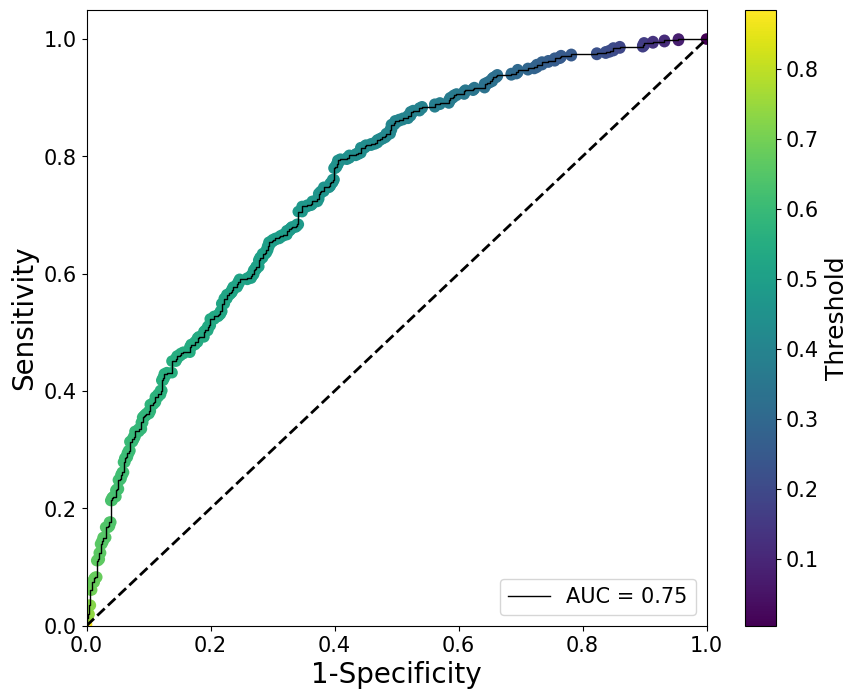

In [23]:
#ROC Curve 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib import cm
import numpy as np


# Calculate ROC curve, AUC, and thresholds
fpr, tpr, thresholds = roc_curve(dataframe['target'], test_predictions)

roc_auc = auc(fpr, tpr)

roc_auc = auc(fpr, tpr)

# Print the AUC
print(f"AUC: {roc_auc:.4f}")

# Create the plot
plt.figure(figsize=(10, 8))
cmap = cm.get_cmap('viridis')  # Choose a colormap

# The scatter plot for the ROC points
sc = plt.scatter(fpr, tpr, c=thresholds, cmap=cmap, edgecolor='none', s =70)

# Optionally, print the thresholds alongside FPR and TPR for inspection
for f, t, thresh in zip(fpr, tpr, thresholds):
    print(f"Threshold: {thresh:.2f}, 1-Specificity: {f:.2f}, Sensitivity: {t:.2f}")

# Plotting the ROC curve
plt.plot(fpr, tpr, color='black', lw=1, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.gca().tick_params(axis='x', labelsize=15)
plt.gca().tick_params(axis='y', labelsize=15)
plt.xlabel('1-Specificity', fontsize=20)
plt.ylabel('Sensitivity', fontsize=20)


# Adding colorbar with custom font for the label
cbar = plt.colorbar(sc)
cbar.set_label('Threshold', size=18)
cbar.ax.tick_params(labelsize=15)

plt.legend(loc="lower right", fontsize= 15)
plt.savefig('ROC LSTM.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()
